# Gene Trajectory Python tutorial: Human myeloid #

GeneTrajectory is a method for inferring gene trajectories in scRNA-seq data, which facilitates understanding of gene dynamics underlying biological processes. The major workflow of GeneTrajectory comprises the following four main steps:

- Step 1. Build a cell-cell kNN graph in which each cell is connected to its k-nearest neighbors. Find the shortest path connecting each pair of cells in the graph and denote its length as the graph distance between cells.
- Step 2. Compute pairwise graph-based Wasserstein distance between gene distributions, which quantifies the minimum cost of transporting the distribution of a given gene into the distribution of another gene in the cell graph.
- Step 3. Generate a low-dimensional representation of genes (using Diffusion Map by default) based on the gene-gene Wasserstein distance matrix. Identify gene trajectories in a sequential manner.
- Step 4. Determine the order of genes along each gene trajectory.

![GT_workflow.png](tutorial_images/GT_workflow.png)

In [1]:
import scanpy as sc

from gene_trajectory.add_gene_bin_score import add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding, extract_gene_trajectory
from gene_trajectory.get_graph_distance import get_graph_distance
from gene_trajectory.gene_distance_shared import cal_ot_mat
from gene_trajectory.run_dm import run_dm
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_3d, plot_gene_trajectory_umap
from gene_trajectory.util.download_file import download_file_if_missing

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Loading example data  ##
The standard preprocessing can be done by employing the scanpy Python package which includes: 
library normalization; finding variable features; scaling; generating PCA embedding (and UMAP embedding for visualization).

We load a preprocessed Scanpy Anndata object where we will perform the gene trajectory inference.

First, we download the data from [figshare](https://figshare.com/articles/dataset/Processed_AnnData_objects_for_GeneTrajectory_inference_Gene_Trajectory_Inference_for_Single-cell_Data_by_Optimal_Transport_Metrics_/25539547), where a copy of the data needed for the tutorial is saved. 


In [3]:
download_file_if_missing('tutorial_data/human_myeloid_scanpy_obj.h5ad', 
    url='https://figshare.com/ndownloader/files/45448603',  
    md5_hash='923f8f00819e9f6401445af8d97275eb',
    create_target_folder_if_missing=True)

Once the file has been downloaded and saved to `tutorial_data/human_myeloid_scanpy_obj.h5ad`, we load the preprocessed Scanpy Anndata object where we will perform the gene trajectory inference.

In [4]:
adata = sc.read_h5ad('tutorial_data/human_myeloid_scanpy_obj.h5ad')

Next, we add a `cell_type` annotation to the metadata based on the clustering labels and plot it in the UMAP representation

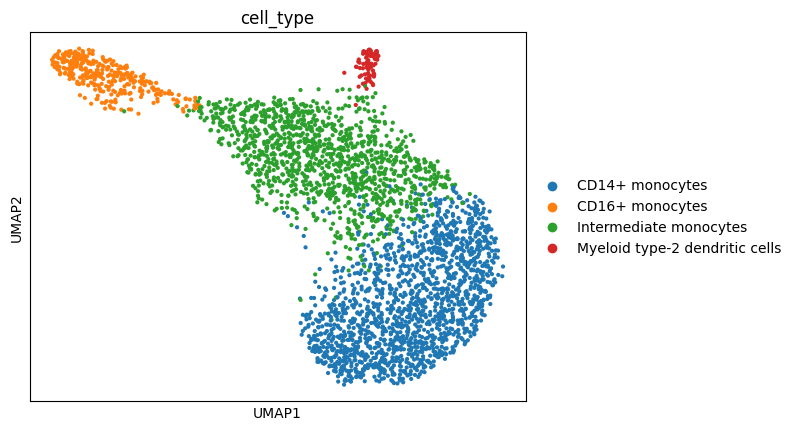

In [5]:
adata.obs['cell_type'] = adata.obs['cluster'].replace({
  0: "CD14+ monocytes",
  1: "Intermediate monocytes",
  2: "CD16+ monocytes",
  3: "Myeloid type-2 dendritic cells"}
)
sc.pl.umap(adata, color=["cell_type"])


## Gene-gene distance computation ##
We narrow down the gene list for gene-gene distance computation by focusing on the top 500 variable genes expressed by 1% - 50% of cells.



In [6]:
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.raw.X.copy()
genes = select_top_genes(adata, layer='counts', n_variable_genes=500)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
len(genes)

251

## Prepare the input for gene-gene Wasserstein distance computation ##

Next, we construct the cell-cell kNN graph and calculate cell-cell graph distances.

In [8]:
run_dm(adata)
cell_graph_dist = get_graph_distance(adata, k=10)

In [9]:
gene_expression_updated, graph_dist_updated = coarse_grain_adata(adata, graph_dist=cell_graph_dist, features=genes, n=500)

In [10]:
gene_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated, 
                           ot_cost=graph_dist_updated, 
                           show_progress_bar=True)

100%|██████████| 31375/31375 [00:14<00:00, 2240.21it/s]


## Gene trajectory inference and visualization ##

Next, we generate the gene embedding by employing Diffusion Map.

In [11]:
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)

The extraction of gene trajectories is done sequentially. The initial node (terminus-1) is defined by the gene with the largest distance from the origin in the Diffusion Map embedding. A random-walk procedure is then employed on the gene graph to select the other genes that belong to the trajectory terminated at terminus-1. After retrieving genes for the first trajectory, we identify the terminus of the subsequent gene trajectory among the remaining genes and repeat the steps above. This is done iteratively until all detectable trajectories are extracted:
- n: the number of trajectories to extract;
- t_list: the time step of random walk to extract each trajectory. Increasing each t extracts a longer trajectory.

Here we use optimized parameters. To see how to optimize parameters with a Jupyter Widget, run the Jupyter notebook in [notebooks/tutorial_human_myeloid.ipynb](https://github.com/KlugerLab/GeneTrajectory-python/blob/main/notebooks/tutorial_human_myeloid.ipynb). 


In [12]:
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, t_list = [4, 8, 7], gene_names=genes, k=5)

Once the gene trajectories are extracted, we can plot them in a 3d plot and show labels for some genes that are important in the system (e.g. `CLEC5A`, `CD1C`, `FCGR3A`, and `PKIB`).

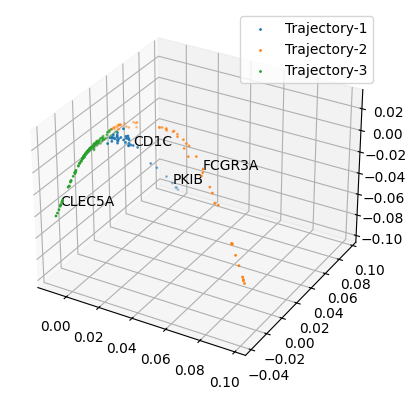

In [13]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])

## Visualize gene bin plots ##

To examine how each given gene trajectory is reflected over the cell graph, we can track how these genes are expressed across different regions in the cell embedding. 
For generating gene bin plots, we use the smooth expression values that are stored in the `alra` layer, which were computed using [ALRA](https://github.com/KlugerLab/ALRA/blob/master/README.md) imputation.


In [14]:
add_gene_bin_score(adata, gene_trajectory=gene_trajectory, n_bins=5, trajectories=3, layer='alra')

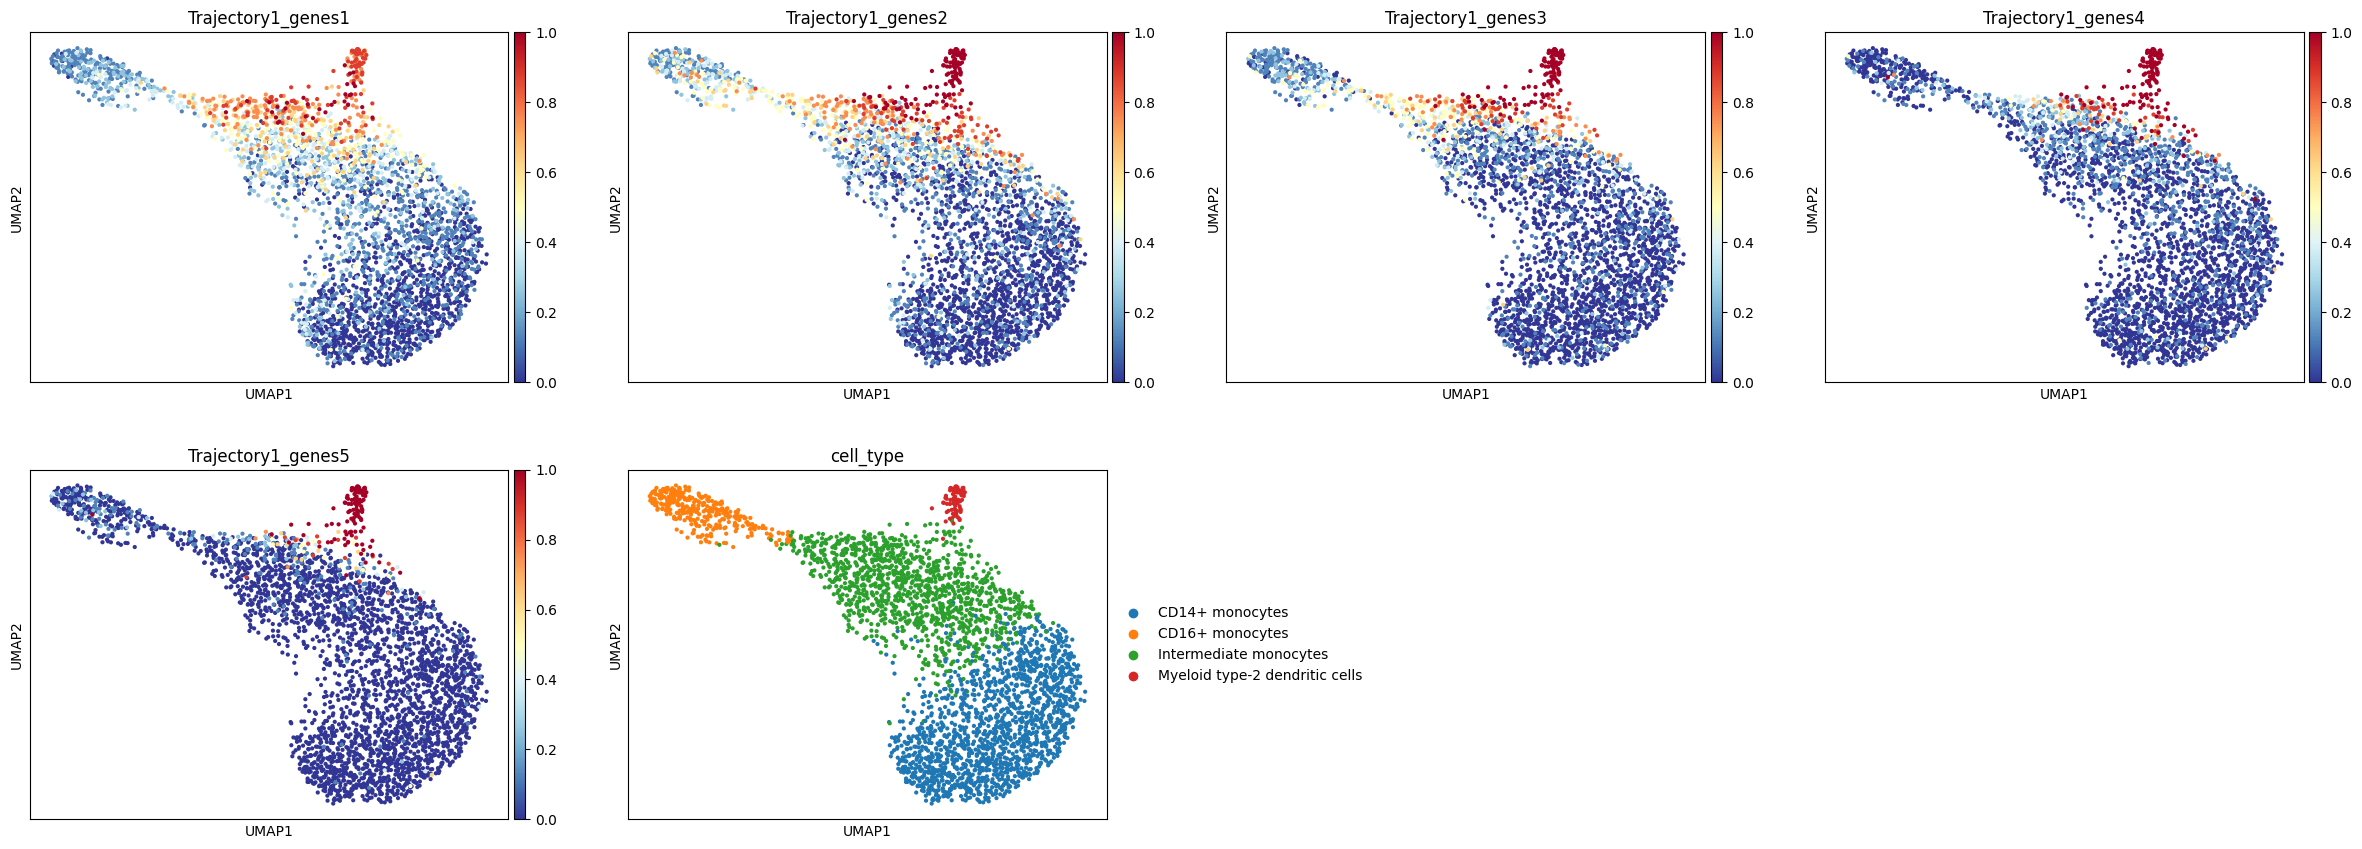

In [15]:
plot_gene_trajectory_umap(adata, 'Trajectory1', other_panels='cell_type')


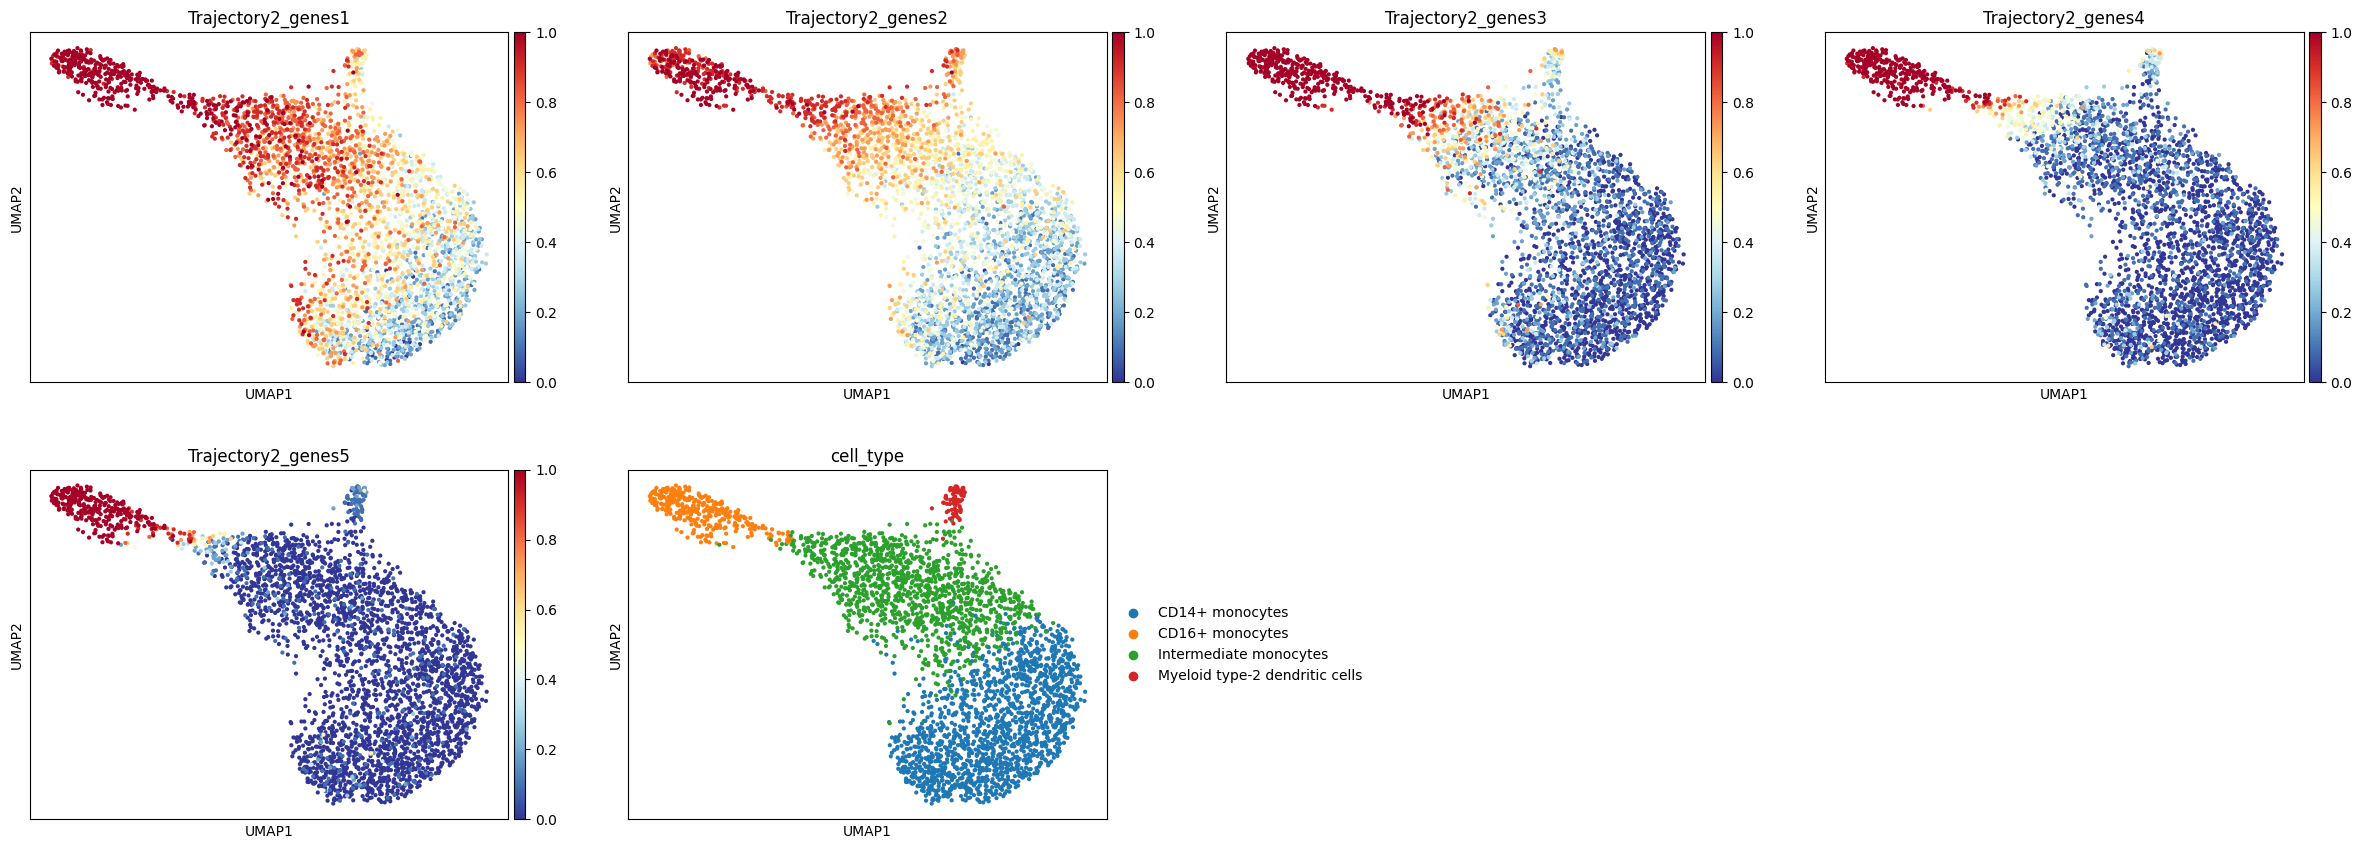

In [16]:
plot_gene_trajectory_umap(adata, 'Trajectory2', other_panels='cell_type')


We plot Trajectory 3 in reverse order as we want the gene `CLEC5A` to be at the end of the trajectory rather than at the beginning

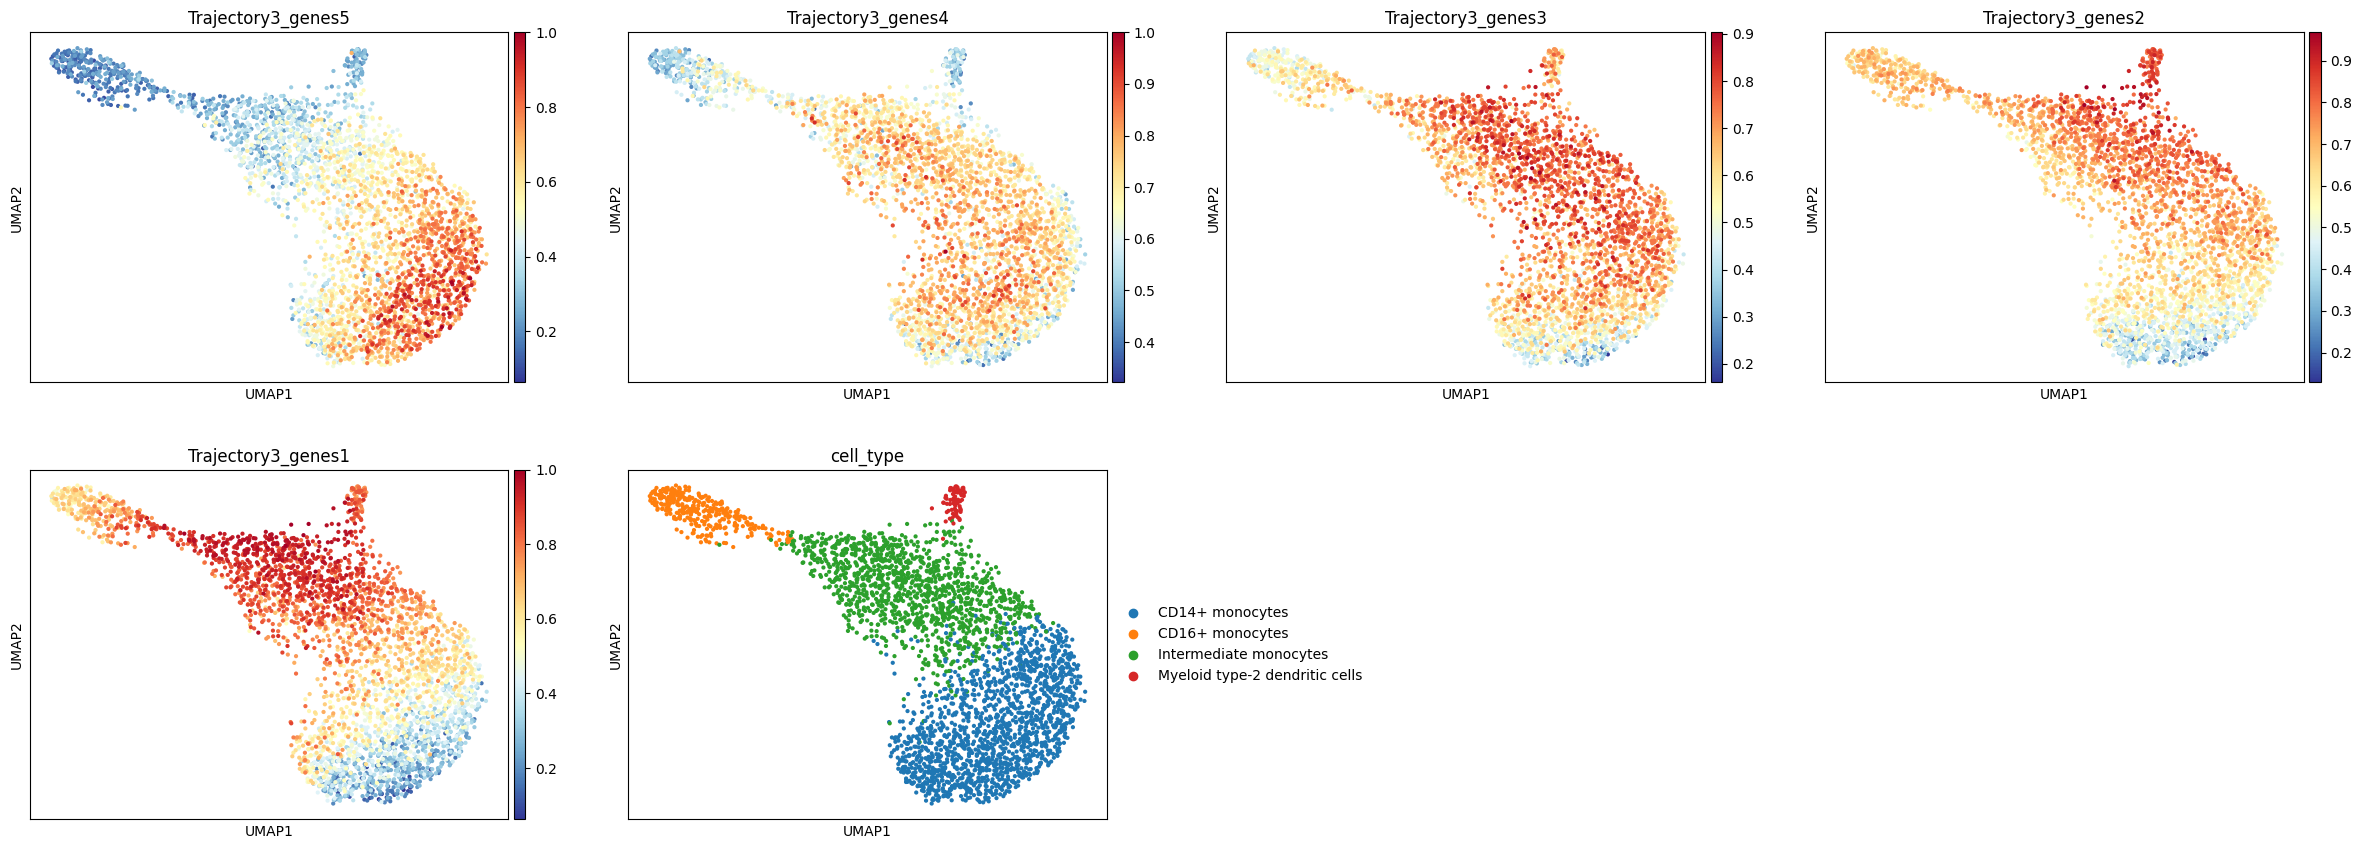

In [17]:
plot_gene_trajectory_umap(adata, 'Trajectory3', other_panels='cell_type', reverse=True)
